# Emojis Speak More than Words

GOAL: 
    1. give an "issue word" as an input (ex. ocasio, climate change) and find the most related emoji
    to kinda grasp people's opinions
    2. give any word or a saying and get a emoji that is most related ex. sparkle --> ✨

Let's make a columns for emojis and its corresponding tweets

# Cleaning

In [71]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

In [72]:
import re
import nltk
import nltk.tokenize as tk
import en_core_web_sm
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/sara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
from nltk.corpus import stopwords

nlp = en_core_web_sm.load()

stopwords = stopwords.words('english')

In [74]:
tweets = list(pickle.load(open('./data/yay_moji.pkl','rb')))
mojis = pd.read_pickle('./data/df_emoji.pkl')

In [75]:
tweets[1]

'Amazing concert yesterday in Paris with @BTS_twt 💜💜🔥🔥 #BTSinParis \n\nRain can’t stop the fire from ARMYs! https://t.co/46b7CSg2WZ'

In [76]:
stopwords.extend(['\'s','’s','rt','…','️','...','follow', 'dm', 'https', 'ur', 'll' ,'amp', 'subscribe', 'don', 've', 'retweet', 'im', 'http'])

In [77]:
# Clean text 
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        tokens = re.sub('@[^\s]+','', tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [78]:
#tweets = pd.DataFrame(tweets, columns=['tweet'])
#tw = [word for word in tweets['tweet']]

# Clean up all text
tw_clean = cleanup_text(tweets)

In [79]:
letters = '🇦 🇧 🇨 🇩 🇪 🇫 🇬 🇭 🇮 🇯 🇰 🇱 🇲 🇳 🇴 🇵 🇶 🇷 🇸 🇹 🇺 🇻 🇼 🇽 🇾 🇿'.split()

In [80]:
flags = mojis['unichar'][1458:]

In [81]:
# change letters to flags
def fix_flags(tweets):
    fixed = []
    for tweet in tweets:
        for l in letters:
            if l in tweet:
                tweet = re.sub(l+" ", l, tweet)
        fixed.append(tweet)
    return(fixed)

In [82]:
tw_clean_flags = fix_flags(tw_clean)

In [83]:
# put space after flag emojis
def flags_space(tweets):
    fixed = []
    for tweet in tweets:
        for l in flags:
            if l in tweet:
                tweet = re.sub(l, l+" ", tweet)
        fixed.append(tweet)
    return(fixed)

In [84]:
tw_cleaned = flags_space(tw_clean_flags)

In [85]:
# complete list of emojis
from emoji import UNICODE_EMOJI

In [86]:
emojis = list(UNICODE_EMOJI.keys())

In [87]:
def extract_mojis(tweets):
    emoji = defaultdict(list)

    for i, tweet in enumerate(tweets):
        for word in tweet.split():
            if word in emojis:
                emoji['emoji'].append(word)
                emoji['index'].append(i)
    
    # delete overlapping emojis in a tweet
    emoji = pd.DataFrame(emoji).drop_duplicates()
    
    return(emoji)

In [88]:
extracted = extract_mojis(tw_cleaned)

In [89]:
def remove_emojis(tweets):
    no_emojis = []
    
    for tweet in tweets:
        tweet = tweet.split()
        words = []
        
        for word in tweet:
            if word not in list(extracted['emoji']):
                words.append(word)
        words = ' '.join(words)
        no_emojis.append(words)
    return(no_emojis)

In [90]:
tw_no_emo = remove_emojis(tw_cleaned)

There are still some unremoved emojis but I will come back to that later. Maybe try tdidf...

In [91]:
tweets_df = pd.DataFrame(tw_no_emo, columns = ['tweets'])

In [92]:
tweets_merged = pd.merge(extracted, tweets_df.reset_index(), on='index', how='left')

In [93]:
# emojis with at least 10 tweets
enough_emoji = tweets_merged.groupby('emoji').count()[tweets_merged.groupby('emoji').count()['tweets']>=10]
enough_emoji = pd.merge(enough_emoji.reset_index()[['emoji']], tweets_merged, on='emoji', how='left')

In [94]:
tweets_merged.head()

,emoji,index,tweets
0,🙏,0,thank undertaker thank goldberg hope guy ok
1,💜,1,amazing concert yesterday paris btsinparis rai...
2,🔥,1,amazing concert yesterday paris btsinparis rai...
3,🚨,2,dallas ⁣ bring 2019 world tour ‘ keep spin nor...
4,2️⃣,2,dallas ⁣ bring 2019 world tour ‘ keep spin nor...


In [95]:
pickle.dump(tweets_merged, open( "./data/tweets_cleaned.pkl", "wb"))

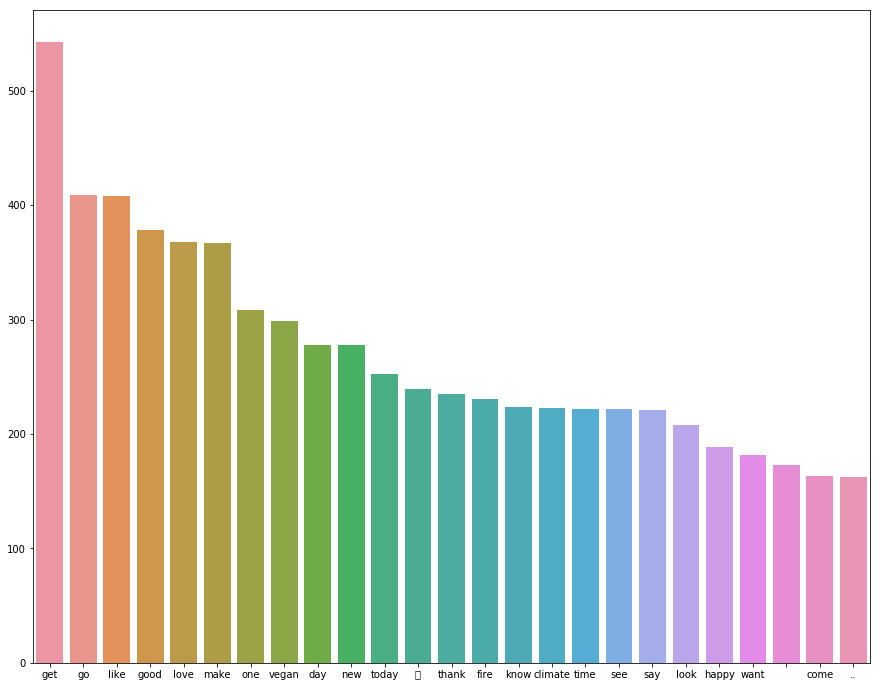

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# Plot top 25 most frequently occuring words
tw = [word for word in tweets_merged['tweets']]
tw = ' '.join(tw).split()
tw_counts = Counter(tw)
tw_common_words = [word[0] for word in tw_counts.most_common(25)]
tw_common_counts = [word[1] for word in tw_counts.most_common(25)]
plt.figure(figsize=(15, 12))
sns.barplot(x=tw_common_words, y=tw_common_counts)
plt.show()

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# Plot top 25 most frequently occuring emojis
tw = [word for word in tweets_merged['emoji']]
tw_counts = Counter(tw)
tw_common_words = [word[0] for word in tw_counts.most_common(25)]
tw_common_counts = [word[1] for word in tw_counts.most_common(25)]
print(pd.DataFrame([tw_common_words,tw_common_counts]))

    0    1    2    3    4    5   6   7   8   9   ...  15  16  17  18  19  20  \
0    😂    😭    ❤    🔥    😍    🤣   🙏   ♀   ✨   🥺  ...   🤔   🤷   👏   🚨   💚   💕   
1  499  270  230  198  139  122  93  87  83  83  ...  68  66  65  61  60  59   

   21  22  23  24  
0   🙄   👍   💙   😩  
1  59  58  58  54  

[2 rows x 25 columns]
